In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset

In [2]:
# Load the dataset as (image,label) tuples and split in 80% train and 20% test data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


# Inspect the dataset

In [3]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


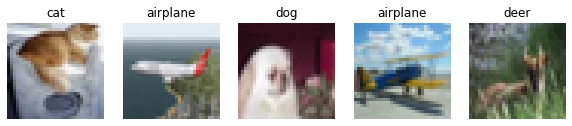

In [4]:
explicit_labels =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(1,5,figsize=(10,15))
for index, sample in enumerate(np.random.choice(train_images.shape[0], 5)):
    ax[index].imshow(train_images[sample])
    ax[index].set_title(explicit_labels[train_labels[sample,0]])
    ax[index].axis("off")

# Preprocess the data

In [5]:
# Set input shape for model
my_input_shape = (train_images.shape[1:])

# Create training and test dataset form the images and labels
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)

# Zip images and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))

# Normalize images and onehot encode the labels
train_dataset = train_dataset.map(lambda img, lbl: (tf.cast(2*(img/255)-1,tf.float32),
                                                    tf.squeeze(tf.one_hot(lbl, 10))),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda img, lbl: (tf.cast(2*(img/255)-1,tf.float32),
                                                  tf.squeeze(tf.one_hot(lbl, 10))),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Cache the preprocessed datasets
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Shuffle the data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)

# Create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

# Prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define transition layer

We can use this layer to **half our input size** and to **reduce or increase the number of input-channels** .  
This is not only needed in our DenseNet but also helpfull when we change the scale in our ResNet.

We inherit from **keras.Model** instead of **keras.layers.Layer** because the **keras.Model** also tracks its internal layers, making them easier to inspect with *Model.summary()*.

In [6]:
from tensorflow.keras import Model, regularizers

class TransitionLayer(Model):
    def __init__(self, channels, regularizer = None):
        super(TransitionLayer, self).__init__()
        self.my_layers = [
            tf.keras.layers.Conv2D(
                filters=channels,
                kernel_size=1,
                padding='same',
                activation=None,
                kernel_regularizer=regularizer
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.AveragePooling2D()
        ]
        
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x, training=training)
        return x

### Test the TransitionLayer

In [7]:
transLayer = TransitionLayer(32)
t = transLayer(tf.zeros([1,32,32,16])) # Input-shape: 32,32,16
t.shape # Output-shape should be 16,16,32

TensorShape([1, 16, 16, 32])

# Define ResidualBlock

In [32]:
from tensorflow.keras import Model, regularizers

class ResidualBlock(Model):
    def __init__(self, filters, kernel_sizes, regularizer = None, dropout_rate = 0):
        super(ResidualBlock, self).__init__()
        self.my_layers = []
        # Add the convolutional layers as specified in the parameters and append Batchnormalzation and ReLU to each
        for my_filter,my_kernel_size in zip(filters, kernel_sizes):       
            self.my_layers.append(
                tf.keras.layers.Conv2D(
                    filters=my_filter,
                    kernel_size=my_kernel_size,
                    padding='same',
                    activation=None,
                    kernel_regularizer=regularizer)
            )                        
            self.my_layers.append(tf.keras.layers.BatchNormalization())
            self.my_layers.append(tf.keras.layers.Dropout(dropout_rate))
            self.my_layers.append(tf.keras.layers.Activation('relu'))
        # Remove the last ReLU layer, we want to add the input to our last output before applying the activation
        del self.my_layers[-1]
        
    def call(self, x, training = False):
        my_input = x
        for layer in self.my_layers:
            x = layer(x, training=training)
        x += my_input
        return tf.keras.activations.relu(x)        

### Test the ResidualBlock

In [9]:
resBlock = ResidualBlock([64,64],[3,3])
_ = resBlock(tf.zeros([1, 32, 32, 64]))
resBlock.summary()

Model: "residual_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  256       
Total params: 74,368
Trainable params: 74,112
Non-trainable params: 256
_________________________________________________________________


# Define the ResNet model

In [33]:
from tensorflow.keras import Model, regularizers

class ResNet(Model):    
    def __init__(self, blocks_per_scale, start_filter, bottleneck = False, regularizer = None, dropout_rate = 0):
        super(ResNet, self).__init__()
        self.conv_in = [
            tf.keras.layers.Conv2D(
                filters=start_filter,
                kernel_size=5,
                strides=2,
                padding='same',
                activation=None,
                kernel_regularizer=regularizer,
                input_shape=my_input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D()
        ]
        
        self.blocks=[]
        my_filters = start_filter
        if bottleneck:
            # Add bottleneck to increase channels to match output of the first ResBlock
            self.blocks.append(
                tf.keras.layers.Conv2D(
                    filters=my_filters*4,
                    kernel_size=1,
                    padding='same',
                    activation=None,
                    kernel_regularizer=regularizer
                )
            )
            # Add bottleneck ResBlocks in every scale
            for num_blocks in blocks_per_scale:
                for _ in range(num_blocks):
                    self.blocks.append(
                        ResidualBlock([my_filters,my_filters,my_filters*4],[1,3,1],regularizer, dropout_rate)
                    )
                # The blocks in the next scale have double the filters
                my_filters *= 2
                # Add TransitionLayer to halve the output size 
                # and increase the channels to match output of the next ResBlock
                self.blocks.append(
                    TransitionLayer(my_filters*4,regularizer)
                )
        else:
            # Add ResBlocks in every scale
            for num_blocks in blocks_per_scale:
                for _ in range(num_blocks):
                    self.blocks.append(
                        ResidualBlock([my_filters,my_filters],[3,3],regularizer, dropout_rate)
                    )
                # The blocks in the next scale have double the filters
                my_filters *= 2
                # Add TransitionLayer to halve the output size 
                # and increase the channels to match output of the next ResBlock
                self.blocks.append(
                    TransitionLayer(my_filters,regularizer)
                )
            
        # Remove last TransitionLayer
        del self.blocks[-1]
        
        self.readout = [
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Dense(
                units=10,
                activation='softmax')
        ]

    def call(self, x, training = True):
        for layer in self.conv_in:
            x = layer(x, training=training)
        for layer in self.blocks:
            x = layer(x, training=training)        
        for layer in self.readout:
            x = layer(x, training=training)            
        return x

### Test the ResNet model

In [11]:
resModel = ResNet([2,3],64,True)
_ = resModel(tf.zeros([1, 32, 32, 3]))
resModel.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  4864      
_________________________________________________________________
batch_normalization_3 (Batch multiple                  256       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  16640     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  71552     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  7155

In [12]:
resModel = ResNet([2,3],64)
_ = resModel(tf.zeros([1, 32, 32, 3]))
resModel.summary()

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           multiple                  4864      
_________________________________________________________________
batch_normalization_21 (Batc multiple                  256       
_________________________________________________________________
activation_21 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
residual_block_6 (ResidualBl multiple                  74368     
_________________________________________________________________
residual_block_7 (ResidualBl multiple                  74368     
_________________________________________________________________
transition_layer_3 (Transiti multiple                  88

# Define ConcatBlock
Here we're defining a block that applies convolution, batchnormalization and ReLU to the input and returns the concatination of its input and output

In [27]:
class ConcatBlock(Model):
    def __init__(self, growth_rate, regularizer = None, dropout_rate = 0):
        super(ConcatBlock, self).__init__()
        self.conv_bn_rl = [
            tf.keras.layers.Conv2D(
                        filters=growth_rate,
                        kernel_size=3,
                        padding='same',
                        activation=None,
                        kernel_regularizer=regularizer),           
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Dropout(dropout_rate)
        ]
        self.concat = tf.keras.layers.Concatenate()

    def call(self, x, training=False):
        my_input = x
        for layer in self.conv_bn_rl:
            x = layer(x, training=training)
        return self.concat([my_input, x])

# Define DenseBlock

In [28]:
class DenseBlock(Model):
    def __init__(self, num_layers, growth_rate, regularizer = None, dropout_rate = 0):
        super(DenseBlock, self).__init__()
        self.my_block = [ConcatBlock(growth_rate,regularizer,dropout_rate) for _ in range(num_layers)]            
        
    def call(self, x, training = False):
        for layer in self.my_block:
            x = layer(x, training=training)
        return x

# Define the DenseNet Model

In [29]:
class DenseNet(Model):
    def __init__(self, layers_per_block, growth_rate, regularizer = None, dropout_rate = 0):
        super(DenseNet, self).__init__()
        self.conv_in = [
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=5,
                strides=2,
                padding='same',
                activation=None,
                kernel_regularizer=regularizer,
                input_shape=my_input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D()
        ]
        
        self.blocks=[]
        
        # Add DenseBlocks
        for num_layers in layers_per_block:
            self.blocks.append(
                DenseBlock(num_layers,growth_rate,regularizer, dropout_rate)
            )
            # Add TransitionLayer to halve the output size and decrease the depth
            self.blocks.append(
                TransitionLayer(num_layers*growth_rate,regularizer)
            )
            
        # Remove last TransitionLayer
        del self.blocks[-1]
        
        self.readout = [
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Dense(
                units=10,
                activation='softmax')
        ]

    def call(self, x, training = True):
        for layer in self.conv_in:
            x = layer(x, training=training)
        for layer in self.blocks:
            x = layer(x, training=training)        
        for layer in self.readout:
            x = layer(x, training=training)            
        return x

### Test the DenseNet model

In [16]:
densemodel = DenseNet(layers_per_block=[4,4,4,4], growth_rate=16, regularizer = None)
_ = densemodel(tf.zeros([1, 32, 32, 3]))
densemodel.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           multiple                  1216      
_________________________________________________________________
batch_normalization_34 (Batc multiple                  64        
_________________________________________________________________
activation_34 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  23360     
_________________________________________________________________
transition_layer_5 (Transiti multiple                  5440      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  51

# Define the training process

#### Function to plot the models performance

In [17]:
from IPython.display import clear_output

def plot_performance(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output(wait=True) 
    fontsize=24
    fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,10))
    ax[0].set_xlim((0,num_epochs))
    ax[0].plot(train_losses,label="Training")
    ax[0].plot(test_losses,label="Test")

    ax[1].set_ylim((0,1))
    ax[1].plot(train_accuracies,label="Training")
    ax[1].plot(test_accuracies,label="Test")

    ax[0].set_ylabel("Loss",fontsize=fontsize)
    ax[1].set_ylabel("Accuracy",fontsize=fontsize)
    ax[1].set_xlabel("Epochs",fontsize=fontsize)
    ax[1].axhline(0.85,xmax=num_epochs,c='g',ls='--')
    ax[0].legend()
    ax[1].legend()
    plt.show()

#### Function to train a given model on a given dataset with given hyperparameter
In the end we get back a dictionary containing the performance measures of the model

In [18]:
def train_model(model, train_dataset, test_dataset, num_epochs, loss_function, optimizer, learning_rate=0.0001):
    running_average_factor = 0.95
    
    # Initialize lists for later visualization.
    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    # Testing model performance on train and test data before learning
    train_loss, train_accuracy = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Display loss and accuracy before training
    print('Starting loss and accuracy:')
    print('Train loss: ',train_loss)
    print('Test loss: ',test_loss)
    print('Train accuracy: ',train_accuracy)
    print('Test accuracy: ',test_accuracy)

    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
        # Training
        running_average_loss = 0
        running_average_accuracy = 0
        for (input,target) in train_dataset:
            train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
            running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

        train_losses.append(running_average_loss.numpy())
        train_accuracies.append(running_average_accuracy.numpy())

        # Testing
        test_loss, test_accuracy = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        #Dynamically plot current accuracy and loss
        plot_performance(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

        # Display loss and accuracy for current epoch    
        print('Epoch: __ ' + str(epoch))
        print('Train loss: ',running_average_loss.numpy())
        print('Test loss: ',test_loss)
        print('Train accuracy: ',running_average_accuracy.numpy())
        print('Test accuracy: ',test_accuracy)
    
    model_performance = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_accuracy": train_accuracies,
        "test_accuracy": test_accuracies,
    }
    return model_performance

# Define training and testing

In [34]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input, training=True)
        loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

@tf.function
def performance_calc(model, input, target, loss_function):
    prediction = model(input, training=False)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        loss, accuracy = performance_calc(model, input, target, loss_function)
        test_loss_aggregator.append(loss.numpy())
        test_accuracy_aggregator.append(accuracy.numpy())

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Train ResNet

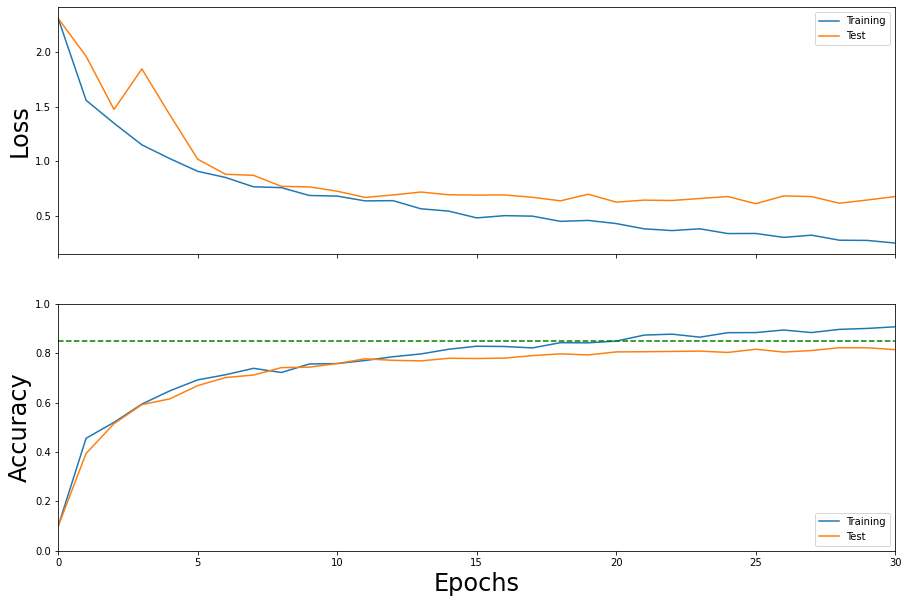

Epoch: __ 29
Train loss:  0.25631627
Test loss:  0.6802025
Train accuracy:  0.9066081
Test accuracy:  0.81409234
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4864      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  16640     
_________________________________________________________________
residual_block (ResidualBloc multiple                  71552     
____________

In [35]:
tf.keras.backend.clear_session()

learning_rate = 0.001
epochs = 30

# Initialize the loss
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
resnet_model = ResNet(blocks_per_scale=[2,3,2], start_filter=64, bottleneck = True, regularizer = None, dropout_rate = 0.3)
resnet_performance = train_model(
    model = resnet_model,
    train_dataset = train_dataset,
    test_dataset=test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer,
    learning_rate = learning_rate
)
resnet_model.summary()

# Define training and testing

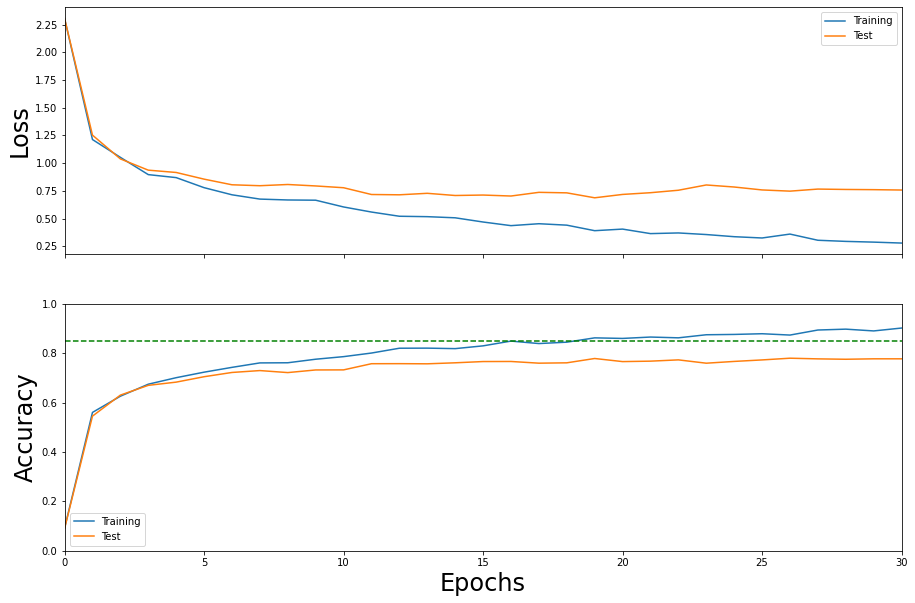

Epoch: __ 29
Train loss:  0.27935278
Test loss:  0.7576155
Train accuracy:  0.90152824
Test accuracy:  0.77697057
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1216      
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  30168     
_________________________________________________________________
transition_layer (Transition multiple                  6696      
_________

In [ ]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input, training=True)
        loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

@tf.function
def performance_calc(model, input, target, loss_function):
    prediction = model(input, training=False)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        loss, accuracy = performance_calc(model, input, target, loss_function)
        test_loss_aggregator.append(loss.numpy())
        test_accuracy_aggregator.append(accuracy.numpy())

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Train DenseNet

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
learning_rate = 0.001
epochs = 30

# Initialize the loss
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
densenet_model = DenseNet(layers_per_block=[6,12,18], growth_rate=12, regularizer = None, dropout_rate = 0.3)
densenet_performance = train_model(
    model = densenet_model,
    train_dataset = train_dataset,
    test_dataset=test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer,
    learning_rate = learning_rate
)
densenet_model.summary()

# Compare performance of our models

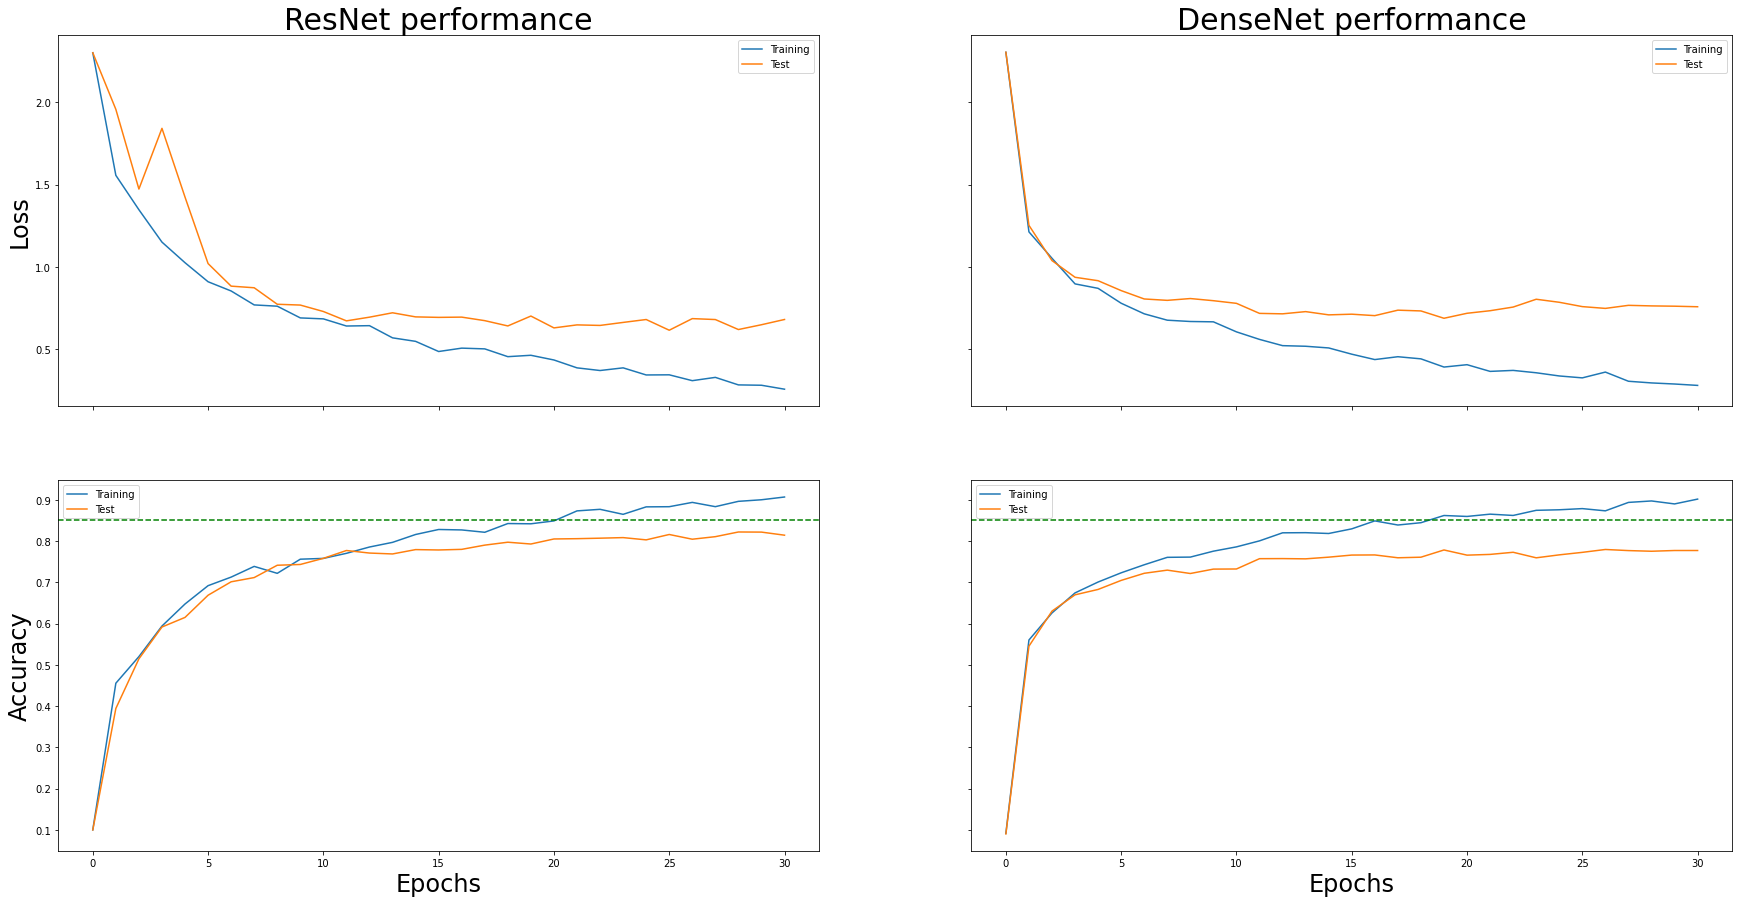

In [36]:
fig, ax = plt.subplots(2,2,sharex='col',sharey='row',figsize=(30,15))

ax[0,0].plot(resnet_performance['train_loss'],label="Training")
ax[0,0].plot(resnet_performance['test_loss'],label="Test")

ax[1,0].plot(resnet_performance['train_accuracy'],label="Training")
ax[1,0].plot(resnet_performance['test_accuracy'],label="Test")

ax[0,1].plot(densenet_performance['train_loss'],label="Training")
ax[0,1].plot(densenet_performance['test_loss'],label="Test")

ax[1,1].plot(densenet_performance['train_accuracy'],label="Training")
ax[1,1].plot(densenet_performance['test_accuracy'],label="Test")

fontsize=24
ax[0,0].set_title("ResNet performance",fontsize=30)
ax[0,1].set_title("DenseNet performance",fontsize=30)
ax[0,0].set_ylabel("Loss",fontsize=fontsize)
ax[1,0].set_ylabel("Accuracy",fontsize=fontsize)
ax[1,0].set_xlabel("Epochs",fontsize=fontsize)
ax[1,1].set_xlabel("Epochs",fontsize=fontsize)
ax[1,0].axhline(0.85,xmax=len(resnet_performance['train_accuracy']),c='g',ls='--')
ax[1,1].axhline(0.85,xmax=len(densenet_performance['train_accuracy']),c='g',ls='--')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()